# Visualize feature performace at the chat level
Directions:
1. Run feature on datasets (python3 featurize.py)
2. Input feature name (column name), dataset, and number of chunks for which you wish to visualize the feature. 
3. 2 generated charts: First is grayscale, darker corresponds to lower values of performance. Second is above/below mean, green is above mean, red is below mean. 

In [1]:
# VISUALIZATION IMPLEMENTATION
import numpy as np
from matplotlib import pyplot as plt, colors
import pandas as pd
from utils.assign_chunk_nums import *
from scipy import stats
import math

target_dict = {"jury": "majority_pct", "csop": "zscore_efficiency", "csopII": "efficiency", "becker": "mean_post_discussion_error_pct", "dat": "score"}

def max_chunks_screening(df, max_chunks):
    if (len(df) == max_chunks):
        return df

def get_feature_data(feature, dataset, chunks):
    chat_fields = ['conversation_num', feature]
    chat_df = pd.read_csv('output/' + dataset + '_output_chat_level.csv', skipinitialspace=True, usecols=chat_fields)
    
    chunked_df = assign_chunk_nums(chat_df, chunks)

    # average feature values
    avg_chunked_df = chunked_df.groupby(['conversation_num', 'chunk_num']).apply(lambda x: x[feature].mean())
    avg_chunked_df = avg_chunked_df.to_frame().rename(columns={0:feature})
    # formatting
    avg_chunked_df = avg_chunked_df.reset_index()
    avg_chunked_df['chunk_num_plt'] = avg_chunked_df.groupby('conversation_num').cumcount() + 1

    full_df = avg_chunked_df.groupby(['conversation_num']).apply(lambda x: max_chunks_screening(x, chunks))

    return full_df.reset_index(drop=True)


def get_target_data(feature, dataset):
    conv_fields = ['conversation_num', target_dict[dataset]]

    # parse feature results from output data
    target_df = pd.read_csv('output/' + dataset + '_output_conversation_level.csv', skipinitialspace=True, usecols=conv_fields)

    # parse target results into workable np array
    np_arr = target_df[target_dict[dataset]].to_numpy()

    # min max normalization
    normalized = (np_arr-np.min(np_arr))/(np.max(np_arr)-np.min(np_arr))

    # zscore standardization
    zscored = stats.zscore(np_arr)

    # concat to dataframe
    target_df['norm'] = pd.Series(normalized)
    target_df['zscore'] = pd.Series(zscored)

    return target_df


def plot_gradient_results(data, category):
	for col in data:
		if (col != 'conversation_num') & (col !='chunk_num') & (col == category):
			plt.figure(figsize=(12, 6))
			for conversation_num, group in data.groupby('conversation_num'):
				plt.plot(group['chunk_num_plt'], group[col], label=f'Conversation {conversation_num}', color=str(group['norm'].iloc[0]))

			plt.xlabel('Chunk Number (Each contains third of chats)')
			plt.xticks([1, 2, 3])
			plt.ylabel(col)
			plt.title(col + ' over time')
			print(col)
			plt.show()

def plot_rg_results(data, category):
	for col in data:
		if (col != 'conversation_num') & (col !='chunk_num') & (col == category):
			plt.figure(figsize=(12, 6))
			for conversation_num, group in data.groupby('conversation_num'):
				color = 'r' if group['zscore'].iloc[0] < 0 else 'g'
				plt.plot(group['chunk_num_plt'], group[col], label=f'Conversation {conversation_num}', color=color)

			plt.xlabel('Chunk Number (Each contains third of chats)')
			plt.xticks([1, 2, 3])
			plt.ylabel(col)
			plt.title(col + ' over time')
			print(col)
			plt.show()

def visualize(feature, dataset, chunks):

    data_to_plot = pd.merge(
            left=get_feature_data(feature, dataset, chunks),
            right=get_target_data(feature, dataset),
            on=['conversation_num'],
            how="inner"
        )
    
    plot_gradient_results(data_to_plot, feature)
    plot_rg_results(data_to_plot, feature)


In [2]:
import matplotlib.patches as mpatches

color_dict = {"jury": "b", "csop": "g", "csopII": "r", "becker": "c", "dat": "m"}

def plot_df_results(data_df, data_labels,category):

    plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots()
    color_patches = []


    for df, label in zip(data_df, data_labels):
        color = color_dict[label]
        color_patches.append(mpatches.Patch(color=color, label= label + ' data'))
        plt.plot()

        
        for conversation_num, group in df.groupby('conversation_num'):
            plt.plot(group['chunk_num_plt'], group[category], label=f'Conversation {conversation_num}', color=color, alpha=0.3, zorder=-10)
        
        # adding AVERAGE line
        avg_df = df.loc[:,[category, 'chunk_num_plt']].groupby('chunk_num_plt').mean().reset_index()
        plt.plot(avg_df['chunk_num_plt'], avg_df[category], color='k', zorder=20)
        plt.text(avg_df['chunk_num_plt'].iloc[-3], avg_df[category].iloc[-3] + 0.05, label)

    plt.rcParams.update({'font.size': 10})
    plt.xticks([1, 2, 3])
    plt.xlabel('Chunk Number (Each contains third of chats)')
    plt.ylabel(category)
    plt.title(category + ' over time')
    ax.legend(handles=color_patches)
    plt.show()

def visualize_arr(feature, datasets, chunks):

    data_arr_to_plot = [pd.merge(
            left=get_feature_data(feature, dataset, chunks),
            right=get_target_data(feature, dataset),
            on=['conversation_num'],
            how="inner"
        ) for dataset in datasets]
    
    plot_df_results(data_arr_to_plot, datasets, feature)


positive_words


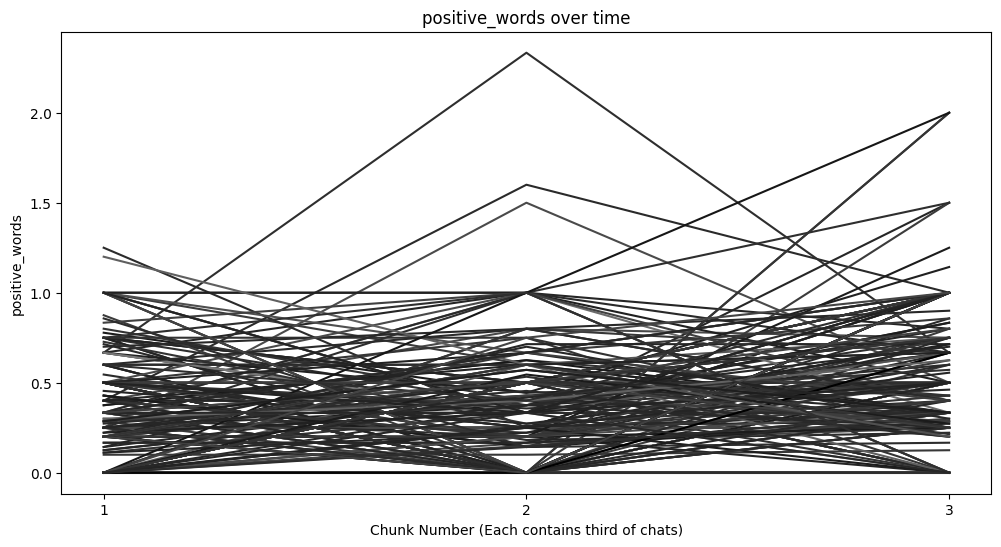

positive_words


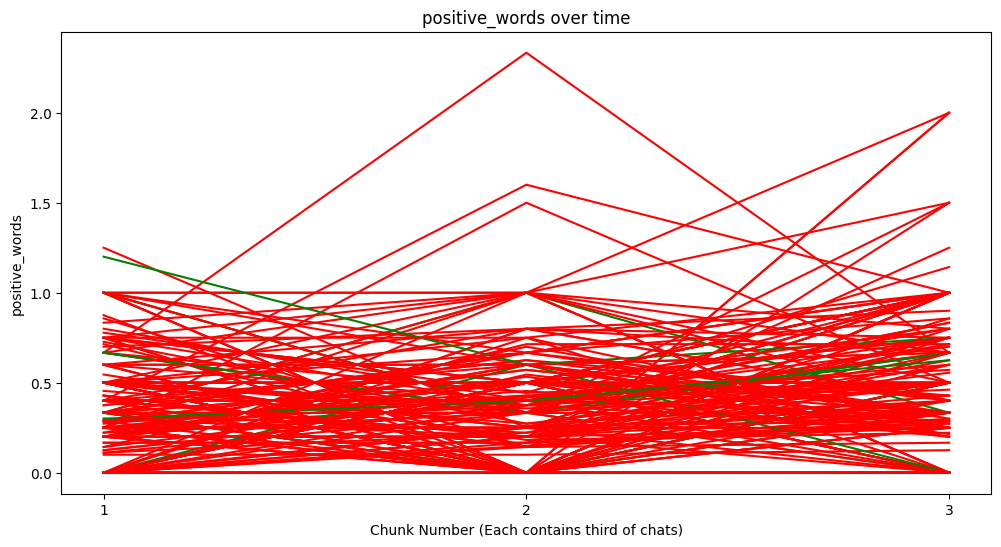

In [6]:
# CALL YOUR VISUALIZATION
# SINGLE
# visualize('positive_words','csop', 3)

# MULTIPLE
# visualize_arr('positivity_wordcount', ['jury', 'csop'], 3)